# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [71]:
import azureml.core 

from azureml.core import Workspace, Experiment, Datastore, Dataset 
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.train.automl import AutoMLConfig

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails

import pandas as pd 
import joblib
import json
import requests

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 2000})

## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [6]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'capstone'

experiment=Experiment(ws, experiment_name)

In [7]:
data=Dataset.get_by_name(ws, name='abalone')

# Data Cleanning

In [9]:
df=data.to_pandas_dataframe()
# Give names to columns
df.columns=['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']
df_dum=pd.get_dummies(df, columns=['Sex'],dummy_na=False)

# Data Inspection

In [10]:
 
df_dum['Rings'].value_counts().sort_values(ascending=False)

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
24      2
27      2
26      1
1       1
25      1
2       1
29      1
Name: Rings, dtype: int64

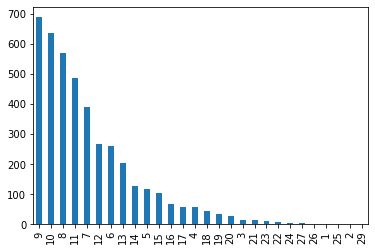

In [11]:
df_dum['Rings'].value_counts().sort_values(ascending=False).plot(kind='bar')

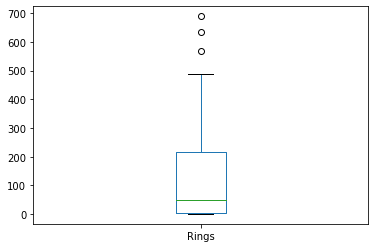

In [12]:
df_dum['Rings'].value_counts().sort_values(ascending=False).plot(kind='box')

In [13]:
df_dum.to_csv('final_frame.csv',index=False)

# Loading Data as Azure Dataset 
datastore = ws.get_default_datastore()
datastore.upload(src_dir='./', target_path='capstone')

dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, ('capstone/final_frame.csv'))])

Uploading an estimated of 19 files
Target already exists. Skipping upload for capstone/.amlignore
Target already exists. Skipping upload for capstone/.amlignore.amltmp
Target already exists. Skipping upload for capstone/abalone.data
Target already exists. Skipping upload for capstone/automl.ipynb
Target already exists. Skipping upload for capstone/automl.ipynb.amltmp
Target already exists. Skipping upload for capstone/automl.log
Target already exists. Skipping upload for capstone/azureml_automl.log
Target already exists. Skipping upload for capstone/final_frame.csv
Target already exists. Skipping upload for capstone/hyperparameter_tuning.ipynb
Target already exists. Skipping upload for capstone/README.md
Target already exists. Skipping upload for capstone/.ipynb_aml_checkpoints/automl-checkpoint2021-4-7-5-54-27.ipynb
Uploading ./.ipynb_aml_checkpoints/automl-checkpoint2021-4-7-15-53-4.ipynb
Uploaded ./.ipynb_aml_checkpoints/automl-checkpoint2021-4-7-15-53-4.ipynb, 1 files out of an est

In [92]:
# Creating Cluster
cluster_name='MLCapstone'

try: 
    cluster=ComputeTarget(workspace=ws,name=cluster_name)
    print('Cluster already Exists')
except ComputeTargetException:
    cluster_config=AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=4)
    cluster=ComputeTarget.create(ws,cluster_name,cluster_config)

cluster.wait_for_completion(show_output=True)

Creating....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

# Classification

In [15]:
# TODO: Put your automl settings here
automl_settings = {'experiment_timeout_minutes': 40,
                   "max_concurrent_iterations": 4,
                   'primary_metric':'AUC_weighted',
                   'task':'classification'}

# TODO: Put your automl config here
automl_config = AutoMLConfig(compute_target=cluster,
                            training_data=dataset,
                            label_column_name='Rings',
                            enable_early_stopping= True,
                            featurization= 'auto',
                            debug_log = "automl.log",
                            **automl_settings)

In [16]:
# TODO: Submit your experiment
remote_run = experiment.submit(automl_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
capstone,AutoML_9713967a-96d5-4cdb-a039-93c20febcdb5,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [17]:
RunDetails(remote_run).show()
remote_run.wait_for_completion(show_output=False)

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

{'runId': 'AutoML_9713967a-96d5-4cdb-a039-93c20febcdb5',
 'target': 'MLCapstone',
 'status': 'Completed',
 'startTimeUtc': '2021-05-08T07:27:47.893703Z',
 'endTimeUtc': '2021-05-08T07:52:43.680638Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'MLCapstone',
  'AMLSettingsJsonString': '{"path":null,"name":"capstone","subscription_id":"939bb7d7-6909-4049-929c-1df590b9f273","resource_group":"presentation","workspace_name":"udacity_workspace","region":"westeurope","compute_target":"MLCapstone","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"iterations":1000,"primary_metric":"AUC_weighted","task_type":"classification","data_script":null,"test_size":0.0,"validation_size":0.0,"n_cross_validati

# Regression 

In [64]:
# choose a name for experiment
experiment_reg_name = 'capstone_regression'

experiment_reg=Experiment(ws, experiment_reg_name)

In [90]:
# TODO: Put your automl settings here
automl_settings_reg = {'experiment_timeout_minutes': 40,
                   "max_concurrent_iterations": 4,
                   'primary_metric':'normalized_mean_absolute_error',
                   'task':'regression'}

# TODO: Put your automl config here
automl_config_reg = AutoMLConfig(compute_target=cluster,
                            training_data=dataset,
                            label_column_name='Rings',
                            enable_early_stopping= True,
                            featurization= 'auto',
                            debug_log = "automl.log",
                            **automl_settings_reg)

In [93]:
# TODO: Submit your experiment
remote_run_reg = experiment_reg.submit(automl_config_reg)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
capstone_regression,AutoML_22d9f483-addb-4e18-9492-f30e1c2276ee,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [67]:
RunDetails(remote_run_reg).show()
remote_run_reg.wait_for_completion(show_output=False)

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

{'runId': 'AutoML_a25ed3fa-6576-4191-99be-e4b4db848807',
 'target': 'MLCapstone',
 'status': 'Completed',
 'startTimeUtc': '2021-05-08T08:32:12.82993Z',
 'endTimeUtc': '2021-05-08T08:57:01.42937Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'MLCapstone',
  'AMLSettingsJsonString': '{"path":null,"name":"capstone_regression","subscription_id":"939bb7d7-6909-4049-929c-1df590b9f273","resource_group":"presentation","workspace_name":"udacity_workspace","region":"westeurope","compute_target":"MLCapstone","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"iterations":1000,"primary_metric":"normalized_mean_absolute_error","task_type":"regression","data_script":null,"test_size":0.

In [ ]:
cluster.delete()

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [69]:
best_run,model=remote_run_reg.get_output()

Package:azureml-automl-runtime, training version:1.27.0.post2, current version:1.26.0
Package:azureml-core, training version:1.27.0, current version:1.26.0
Package:azureml-dataprep, training version:2.14.2, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.12.1, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.27.0, current version:1.26.0
Package:azureml-defaults, training version:1.27.0, current version:1.26.0
Package:azureml-interpret, training version:1.27.0, current version:1.26.0
Package:azureml-mlflow, training version:1.27.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.27.0, current version:1.26.0
Package:azureml-telemetry, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.27.0.post1,

In [76]:
model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('1',
                                            Pipeline(memory=None,
                                                     steps=[('maxabsscaler',
                                                             MaxAbsScaler(copy=True)),
                                                            ('xgboostregressor',
                                                             XGBoostRegressor(base_score=0.5,
                                                                              booster='gbtree',
                                       

Current provisioning state of AmlCompute is "Deleting"



In [77]:
joblib.dump(model, 'automl_capstone.joblib')

['automl_capstone.joblib']

# Retrieving Best Model

In [96]:
model_name=best_run.properties['model_name']

model_registered=remote_run.register_model(model_name=model_name, description="Abalone Model")

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"



# Deploying Model

In [79]:
from azureml.core.model import InferenceConfig 
from azureml.core.webservice import AciWebservice, Webservice 
from azureml.core.model import Model 
from azureml.core import Environment 
from azureml.automl.core.shared import constants

In [80]:
# Score Script
best_run.download_file("outputs/scoring_file_v_1_0_0.py","scripts/score.py")

# Environment Information
best_run.download_file(constants.CONDA_ENV_FILE_PATH, "conda_env.yml")
conda_environment = Environment.from_conda_specification(name='conda_env',file_path="conda_env.yml")

# Inference Config 
inference_config=InferenceConfig(entry_script="scripts/score.py", environment=conda_environment)

Current provisioning state of AmlCompute is "Deleting"



In [81]:
# Defininf ACI- Deployment
aci_config=AciWebservice.deploy_configuration(cpu_cores=1,memory_gb=2,description="capstone-abalone-classification",enable_app_insights=True,auth_enabled=True)

# Deploy 
service=Model.deploy(ws,"auto-abalone",[model_registered],inference_config,aci_config)

In [82]:
service.wait_for_deployment(True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-08 09:02:47+00:00 Creating Container Registry if not exists.
2021-05-08 09:02:48+00:00 Registering the environment.
2021-05-08 09:02:49+00:00 Use the existing image.
2021-05-08 09:02:49+00:00 Generating deployment configuration.
2021-05-08 09:02:50+00:00 Submitting deployment to compute.Current provisioning state of AmlCompute is "Deleting"

.
2021-05-08 09:02:58+00:00 Checking the status of deployment auto-abalone..
2021-05-08 09:05:58+00:00 Checking the status of deployment auto-abalone..
2021-05-08 09:08:20+00:00 Checking the status of inference endpoint auto-abalone.
2021-05-08 09:08:22+00:00 Checking the status of inference endpoint auto-abalone.
Succeeded
ACI service creation operation finished, operation "Succeeded"


## Endpoint Testing

In [121]:
uri=service.scoring_uri

# uri = 'Your URI' if seperatly deployd

key='Your KEY'

headers = {'Content-Type':'application/json'}

headers['Authorization'] = 'Bearer {}'.format(key)


test_1 = json.dumps({'data':[{
    'Length':0.46,
    'Diameter':0.36,
    'Height':0.10,
    'Whole weight':0.51,
    'Shucked weight':0.22,
    'Viscera weight':0.10,
    'Shell weight':0.15,
    'Sex_F':0,
    'Sex_I':0,
    'Sex_M':1}
    ]
        })

test_2 = json.dumps({'data':[{
    'Length':0.22,
    'Diameter':0.81,
    'Height':0.48,
    'Whole weight':0.53,
    'Shucked weight':0.35,
    'Viscera weight':0.15,
    'Shell weight':0.11,
    'Sex_F':1,
    'Sex_I':0,
    'Sex_M':0}
    ]
        })

test_3 = json.dumps({'data':[{
    'Length':0.36,
    'Diameter':0.25,
    'Height':0.15,
    'Whole weight':0.58,
    'Shucked weight':0.26,
    'Viscera weight':0.18,
    'Shell weight':0.21,
    'Sex_F':0,
    'Sex_I':1,
    'Sex_M':0}
    ]
        })



TODO: In the cell below, send a request to the web service you deployed to test it.

In [124]:
for i in [test_1,test_2,test_3]:
    response = requests.post(uri, data=i, headers=headers)
    print(response.text)

"{\"result\": [8]}"
"{\"result\": [12]}"
"{\"result\": [16]}"


TODO: In the cell below, print the logs of the web service and delete the service

In [125]:
service.get_logs()

'2021-05-08T09:08:15,569776600+00:00 - rsyslog/run \n2021-05-08T09:08:15,573808200+00:00 - iot-server/run \nrsyslogd: /azureml-envs/azureml_f8f5ff2f983718fa04a09abf22f98303/lib/libuuid.so.1: no version information available (required by rsyslogd)\n2021-05-08T09:08:15,592126700+00:00 - gunicorn/run \n2021-05-08T09:08:15,624163000+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_f8f5ff2f983718fa04a09abf22f98303/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_f8f5ff2f983718fa04a09abf22f98303/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_f8f5ff2f983718fa04a09abf22f98303/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_f8f5ff2f983718fa04a09abf22f98303/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx

In [126]:
service.delete()